<a href="https://colab.research.google.com/github/lakshmi-keerthi/Synthetic-Face-Generator-using-GAN/blob/main/Synthetic_Face_Generator_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub


In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)


100%|██████████| 1.33G/1.33G [00:16<00:00, 84.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [3]:
import os

files_and_dirs = os.listdir(path)
print("Files and directories in path:")
for item in files_and_dirs:
    print(item)


Files and directories in path:
img_align_celeba
list_eval_partition.csv
list_landmarks_align_celeba.csv
list_bbox_celeba.csv
list_attr_celeba.csv


In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = os.path.join(path, "img_align_celeba/img_align_celeba")
image_files = os.listdir(image_folder)

print("Number of images:", len(image_files))

Number of images: 202599


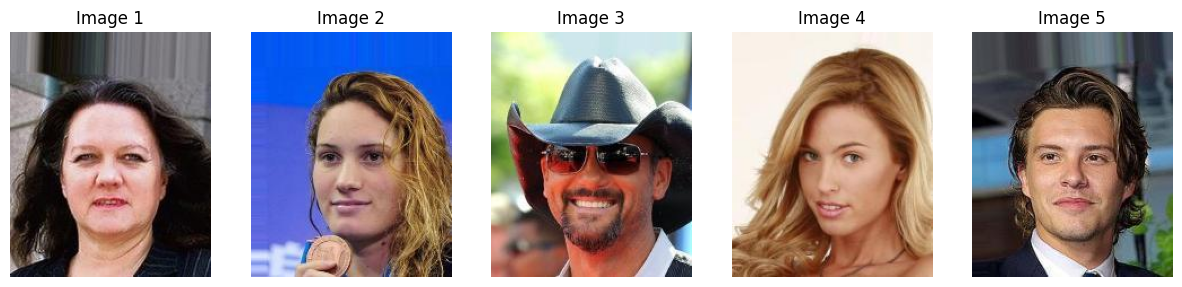

In [5]:
import random
random_images = random.sample(image_files, 5)

# Display the images
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(random_images):
    img_path = os.path.join(image_folder, img_file)
    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

def build_generator(latent_dim):
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(8 * 8 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return model

# Define the discriminator
def build_discriminator(input_shape):
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=input_shape))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [7]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# Hyperparameters
latent_dim = 100
img_shape = (64, 64, 3)
batch_size = 64
epochs = 10000

# Build generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy")

# Compile GAN
gan = GAN(generator=generator, discriminator=discriminator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
def load_kaggle_images(image_folder, target_size=(64, 64)):
    images = []
    image_files = os.listdir(image_folder)

    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        img = Image.open(img_path).resize(target_size)  # Resize to target size
        img = np.array(img) / 127.5 - 1.0  # Normalize to [-1, 1]
        images.append(img)

    return np.array(images)

In [ ]:
def preprocess_images(images):
    images = images / 127.5 - 1.0  # Normalize to [-1, 1]
    return images

images = load_kaggle_images(image_folder)
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
for epoch in range(epochs):
    for real_images in dataset:
        gan.train_step(real_images)

    if epoch % 100 == 0:
        random_latent_vectors = tf.random.normal(shape=(5, latent_dim))
        generated_images = generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.show()